In [34]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential  # Poprawiony import z TensorFlow
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import keras 
from sklearn.linear_model import LassoCV
from sklearn.datasets import fetch_california_housing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt

Loss functions

In [59]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

In [60]:
def NWJ_loss(y_true, y_pred):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(y_pred, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(y_pred-1), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term) 

Neural net

In [71]:
def neural_net(x, y, loss_fun=DV_loss):
    model_inputs = keras.Input(shape=(x.shape[1],))
    layer_out = Dense(128, activation='relu', kernel_initializer='he_normal')(model_inputs)
    layer_out = BatchNormalization()(layer_out)
    layer_out = Dropout(0.5)(layer_out)
    layer_out = Dense(128, activation='relu', kernel_initializer='he_normal')(layer_out)
    layer_out = BatchNormalization()(layer_out)
    model_outputs = Dense(1)(layer_out)
    model = keras.Model(model_inputs, model_outputs)

    optimizer = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model.compile(optimizer=optimizer, loss=loss_fun)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    hist = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_test, y_test), callbacks=[es, reduce_lr])
    return hist

## Estimators

In [85]:
# W metodzie z Runge-KNN chcemy stworzyć taki X_perm, żeby CMI(X_perm,Y|Z) = 0, czyli X_perm był warunkowo niezależny od Y pod warunkiem Z
# Czyli nie chcemy tak bezpośrednio wyestymować p(x,z)p(y|z), tylko dostać próbę , w której (X_perm, Z) i (X_perm, Y) bedą miały takie same rozkłady 
# jak (X, Z) i (X, Y), ale (X,Y,Z) będzie z rozkladu p(x,z)p(y|z)=p(x|z)p(y|z)p(z)
# (przy czym oryginalne dane są z p(x,y,z))

# czyli teraz mamy próbę z p(x,y,z) -> (X,Y,Z) i próbę z p(x,z)p(y|z) -> (X_perm, Y, Z)

### a) kNN method

In [91]:
# w tej części chcemy skorzystać z tego, że CMI = D_KL (definicja 2 z Mukherjee)
# i skorzystać z lab 7, żeby wyliczać D_KL(p(x,y,z)||p(x,z)p(y|z))

In [95]:
def kNN_shaffle_X(X, Y, Z, k_perm=5):
    n = len(X)
    assert len(Y) == n and len(Z) == n, "Input arrays must have the same length."

    # Compute nearest neighbors for each sample point in z
    tree = cKDTree(Z)
    nearest_neighbors = [tree.query_ball_point(Z[i], r=k_perm) for i in range(n)]

    # Initialize empty list U and array X*
    used_indices = set()
    X_star = np.zeros_like(X)

    # Shuffle nearest neighbor lists
    shuffled_neighbors = [np.random.permutation(neighbors) for neighbors in nearest_neighbors]

    # Create random permutation of indices
    permutation = np.random.permutation(n)

    # Assign surrogate values
    for i in permutation:
        m = 0
        while m < len(shuffled_neighbors[i]):
            j = shuffled_neighbors[i][m]
            if j not in used_indices:
                X_star[i] = X[j]
                used_indices.add(j)
                break
            m += 1

    return X_star

In [96]:
def est1(X, Y, Z, kperm=5, loss_fun=DV_loss, if_fun_plot=0):
    X_perm = kNN_shaffle_X(X, Y, Z, kperm)

    # we adapt x_train and y_train
    sample_original = np.hstack([X,Y,Z])
    sample_conditional_independence = np.hstack([X_perm,Y,Z])

    # x_train consists of both (X,Y,Z) and (X_perm, Y, Z) concatenated
    x = np.vstack([sample_original, sample_conditional_independence])
    # y_train: y_i=1 if the observation comes from (X,Y,Z) and y_i=0 if (X_perm, Y, Z), i=1,2,...,2*n_samples
    y = np.concatenate((1.0*np.ones(n_samples), 0.0*np.ones(n_samples)))

    hist = neural_net(x, y, loss_fun)

    if if_fun_plot == 1:
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.show()

    # cmi
    return max(0.0, -hist.history['loss'][-1])

### b) chain rule

In [66]:
# estymujemy MI((X,Z), Y) jak w: pierwszy myślnik druga kropka
# estymujemy MI((X), Y) jak w: pierwszy myślnik druga kropka

# potem żeby dostać CMI: MI((X,Z), Y) - MI((X), Y) - czyli korzystamy z drugiego myślnika pierwszej kropki

Estymacja MI

In [67]:
def est_mi(X, Y, loss_fun, if_fun_plot):
    # p(X,Z,Y)
    XY = np.hstack([X, Y])
    # p(X,Z)p(Y)
    Y_perm = np.random.permutation(Y)
    X_Y = np.hstack([X, Y_perm])
    x = np.vstack([XY, X_Y])
    y = np.concatenate((1.0*np.ones(n_samples), 0.0*np.ones(n_samples)))

    hist = neural_net(x, y, loss_fun)

    if if_fun_plot == 1:
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.show()

    return max(0.0, -hist.history['loss'][-1])

Estymacja CMI

In [68]:
def est2(X, Y, Z, loss_fun=DV_loss, if_fun_plot=0):
    # est I((X,Z),Y)
    XZ = np.hstack([X,Z])
    I_XZ_Y = est_mi(XZ, Y, loss_fun, if_fun_plot)
    # est I(X,Y)
    I_X_Y = est_mi(X, Y, loss_fun, if_fun_plot)

    # cmi
    return max(0.0, I_XZ_Y - I_X_Y) 

In [124]:
est2(X, Y, Z, DV_loss, 0)

0.0

### c) comparative estimator

In [14]:
def mutual_info(X, Y):
    """Oblicza wzajemną informację między X a Y."""
    return mutual_info_regression(X, Y, discrete_features=False, n_neighbors=10).sum()

def estimate_cmi(X, Y, Z):
    """Oblicza wzajemną informację warunkową I(X, Y | Z)."""

    # I(X, Z; Y)
    XZ = np.hstack([X, Z])
    I_XZY = mutual_info(XZ, Y)
    print("I_XZY:", I_XZY)

    # I(X; Y)
    I_XY = mutual_info(X, Y)
    print("I_XY:", I_XY)

    # I(X, Y | Z) = I(X, Z; Y) - I(X; Y)
    I_XY_given_Z = I_XZY - I_XY
    return I_XY_given_Z

## Data and experiments

###   An example, for which the formula for CMI is known and exact CMI can be computed (on a grid of parameters)

example1

In [15]:
# Function to compute exact CMI for Gaussian variables
def compute_gaussian_cmi(sigma):

    
    sigma_xz = sigma[:2, :2]  
    sigma_yz = sigma[1:, 1:]  
    sigma_xyz = sigma 

    det_xz = np.linalg.det(sigma_xz)
    det_yz = np.linalg.det(sigma_yz)
    det_xyz = np.linalg.det(sigma_xyz)

    cmi = 0.5 * np.log(det_xz * det_yz / det_xyz)
    return cmi

I_XZY: 0.011094693914565745
I_XY: 0.007274237816185192
I_XZY: 0.041086471339506936
I_XY: 0.025888980932256445
I_XZY: 0.08347890925272683
I_XY: 0.04122077349501296
I_XZY: 0.13300303612588582
I_XY: 0.06162324541428088
I_XZY: 0.18966496176993797
I_XY: 0.09553614068615968
I_XZY: 0.2828460591445241
I_XY: 0.1459088502351511
I_XZY: 0.3809413330040856
I_XY: 0.19017079767088063
I_XZY: 0.532126030712309
I_XY: 0.2552420554438237
Pominięto rho=0.7222222222222222 - macierz kowariancji nie jest dodatnio określona
Pominięto rho=0.8 - macierz kowariancji nie jest dodatnio określona


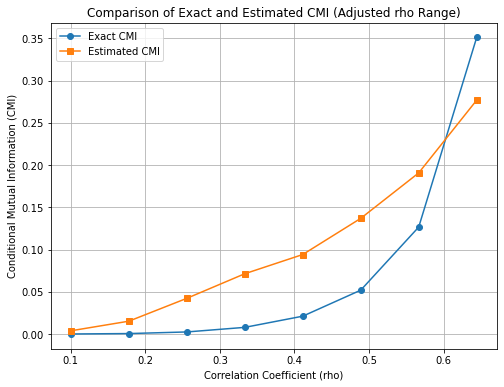

In [31]:
import numpy as np
import matplotlib.pyplot as plt

grid_size = 10
results = []

rho_values = np.linspace(0.1, 0.8, grid_size) 
for rho in rho_values:
    
    sigma = np.array([
        [1, rho, 0],
        [rho, 1, rho],
        [0, rho, 1]
    ])

    # Sprawdzanie dodatniej określoności macierzy
    if np.all(np.linalg.eigvals(sigma) > 0):  
        # Generowanie danych
        mean = np.zeros(3)
        data = np.random.multivariate_normal(mean, sigma, size=10000)
        X = data[:, [0]]
        Y = data[:, [1]]
        Z = data[:, [2]]
        
        
        exact_cmi = compute_gaussian_cmi(sigma)
        estimated_cmi = estimate_cmi(X, Y.ravel(), Z)

        
        results.append((rho, exact_cmi, estimated_cmi))
    else:
        print(f"Pominięto rho={rho} - macierz kowariancji nie jest dodatnio określona")


rho_values_valid = [item[0] for item in results]
exact_cmi_values = [item[1] for item in results]
estimated_cmi_values = [item[2] for item in results]

# Tworzenie wykresu
plt.figure(figsize=(8, 6))
plt.plot(rho_values_valid, exact_cmi_values, label="Exact CMI", marker='o')
plt.plot(rho_values_valid, estimated_cmi_values, label="Estimated CMI", marker='s')
plt.xlabel("Correlation Coefficient (rho)")
plt.ylabel("Conditional Mutual Information (CMI)")
plt.title("Comparison of Exact and Estimated CMI (Adjusted rho Range)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt

grid_size = 10
results = []

rho_values = np.linspace(0.1, 0.8, grid_size)  
for rho in rho_values:
    
    sigma = np.array([
        [1, rho, 0],
        [rho, 1, rho],
        [0, rho, 1]
    ])

    # Sprawdzanie dodatniej określoności macierzy
    if np.all(np.linalg.eigvals(sigma) > 0):
        # Generowanie danych
        mean = np.zeros(3)
        data = np.random.multivariate_normal(mean, sigma, size=10000)
        X = data[:, [0]]
        Y = data[:, [1]]
        Z = data[:, [2]]
        
        
        exact_cmi = compute_gaussian_cmi(sigma)
        estimated_cmi = est1(X, Y, Z, 5, DV_loss, 0)
        
        results.append((rho, exact_cmi, estimated_cmi))
    else:
        print(f"Pominięto rho={rho} - macierz kowariancji nie jest dodatnio określona")

rho_values_valid = [item[0] for item in results]
exact_cmi_values = [item[1] for item in results]
estimated_cmi_values = [item[2] for item in results]

# Tworzenie wykresu
plt.figure(figsize=(8, 6))
plt.plot(rho_values_valid, exact_cmi_values, label="Exact CMI", marker='o')
plt.plot(rho_values_valid, estimated_cmi_values, label="Estimated CMI", marker='s')
plt.xlabel("Correlation Coefficient (rho)")
plt.ylabel("Conditional Mutual Information (CMI)")
plt.title("Comparison of Exact and Estimated CMI (Adjusted rho Range)")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.5442 - val_loss: 0.0627 - learning_rate: 1.0000e-04
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3566 - val_loss: 0.0518 - learning_rate: 1.0000e-04
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2518 - val_loss: 0.0340 - learning_rate: 1.0000e-04
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2084 - val_loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1399 - val_loss: 0.0212 - learning_rate: 1.0000e-04
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1355 - val_loss: 0.0200 - learning_rate: 1.0000e-04
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1206 - val_loss: 0.0163 - learning_rate: 1.0000e-04
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0999 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0792 - val_loss: 

KeyboardInterrupt: 

example2

In [34]:
##dane niezależne 
np.random.seed(42)
sigma = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

mean = np.zeros(3)
data = np.random.multivariate_normal(mean, sigma, size=10000)
X = data[:, [0]]
Y = data[:, [1]]
Z = data[:, [2]]

In [35]:

exact_cmi = compute_gaussian_cmi(sigma)


estimated_cmi = est2(X, Y, Z, NWJ_loss, 0) 
exact_cmi, estimated_cmi

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1.1335 - val_loss: 0.6003 - learning_rate: 1.0000e-04
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5670 - val_loss: 0.3609 - learning_rate: 1.0000e-04
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3757 - val_loss: 0.2264 - learning_rate: 1.0000e-04
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2801 - val_loss: 0.1379 - learning_rate: 1.0000e-04
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2385 - val_loss: 0.1113 - learning_rate: 1.0000e-04
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1923 - val_loss: 0.0805 - learning_rate: 1.0000e-04
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1492 - val_loss: 0.0635 - learning_rate: 1.0000e-04
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1355 - val_loss: 0.0512 - learning_rate: 1.0000e-04
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1316 - val_loss: 

(0.0, 0.0)

## A simulation example of ranking variable importance based on our estimators

In [139]:
# Miary jakości
def count_inversions(rank1, rank2):
    """Liczy liczbę odwróconych par między dwoma rankingami."""
    inversions = 0
    for i in range(len(rank1)):
        for j in range(i + 1, len(rank1)):
            if (rank1[i] < rank1[j] and rank2[i] > rank2[j]) or (rank1[i] > rank1[j] and rank2[i] < rank2[j]):
                inversions += 1
    return inversions

def top_k_agreement(rank1, rank2, k):
    """Liczy, ile zmiennych z top k w rankingu 1 pojawi się w top k w rankingu 2."""
    top_k_rank1 = set(rank1[:k])
    top_k_rank2 = set(rank2[:k])
    return len(top_k_rank1 & top_k_rank2) / k


### 2 przyklad 1


In [ ]:
# Generowanie danych (10000 próbek, 20 zmiennych)
np.random.seed(42)
n_samples = 10000
n_features = 20
X, Y = make_regression(n_samples=n_samples, n_features=n_features, noise=0.1, random_state=42)

# Dodajemy sztucznie silniejsze cechy
X[:, 10] = X[:, 0] * 3 + np.random.normal(0, 0.1, n_samples)
X[:, 6] = X[:, 1] * 2 + np.random.normal(0, 0.1, n_samples)
X[:, 15] = X[:, 2] * 2 + np.random.normal(0, 0.1, n_samples)

# Ranking na podstawie LASSO
lasso = LassoCV(cv=5).fit(X, Y)
lasso_importances = np.abs(lasso.coef_)
lasso_ranking = np.argsort(lasso_importances)[::-1]
Y = Y.reshape(-1, 1)

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7156 - val_loss: 0.0259 - learning_rate: 1.0000e-04
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4232 - val_loss: 0.0156 - learning_rate: 1.0000e-04
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2641 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2390 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1764 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1286 - val_loss: 0.0042 - learning_rate: 1.0000e-04
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1035 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0880 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0769 - val_loss: 

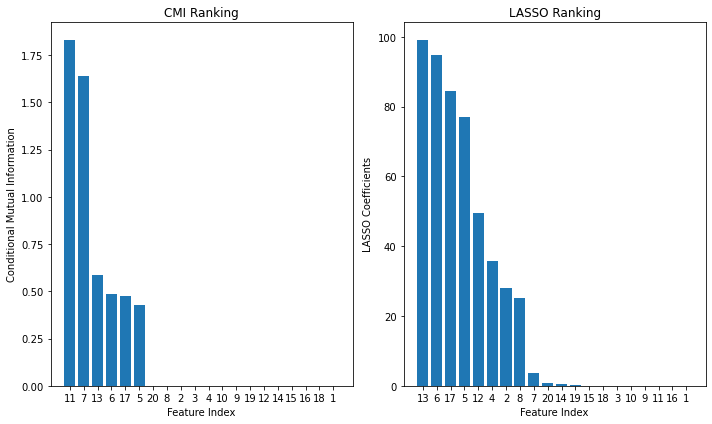

Top 10 zmiennych na podstawie CMI: [11  7 13  6 17  5 20  8  2  3]
Top 10 zmiennych na podstawie LASSO: [13  6 17  5 12  4  2  8  7 20]
Liczba odwróconych par: 78
Top 10 agreement score: 0.8
Top 5 agreement score: 0.6


In [149]:
#est1

cmi_scores = []
for i in range(X.shape[1]):
    # Zmienna Z to wszystkie cechy oprócz jednej
    Z = np.delete(X, i, axis=1)
    cmi_scores.append(est1(X[:, i].reshape(-1, 1), Y, Z))

cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

plt.bar(range(1, n_features + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, n_features + 1), np.array(lasso_importances)[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlanie top 10 zmiennych
print("Top 10 zmiennych na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 zmiennych na podstawie LASSO:", lasso_ranking[:10] + 1)


# Liczenie liczby odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Liczenie liczby przypadków, w których top 10 zmiennych się pokrywają
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Top 10 agreement score: {top_k_agreement_10}")
print(f"Top 5 agreement score: {top_k_agreement_5}")


Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5741 - val_loss: -0.0011 - learning_rate: 1.0000e-04
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3015 - val_loss: -0.0147 - learning_rate: 1.0000e-04
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1816 - val_loss: -0.0302 - learning_rate: 1.0000e-04
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1309 - val_loss: -0.0447 - learning_rate: 1.0000e-04
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1046 - val_loss: -0.0468 - learning_rate: 1.0000e-04
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0767 - val_loss: -0.0796 - learning_rate: 1.0000e-04
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0436 - val_loss: -0.0935 - learning_rate: 1.0000e-04
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0237 - val_loss: -0.1229 - learning_rate: 1.0000e-04
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0068 - v

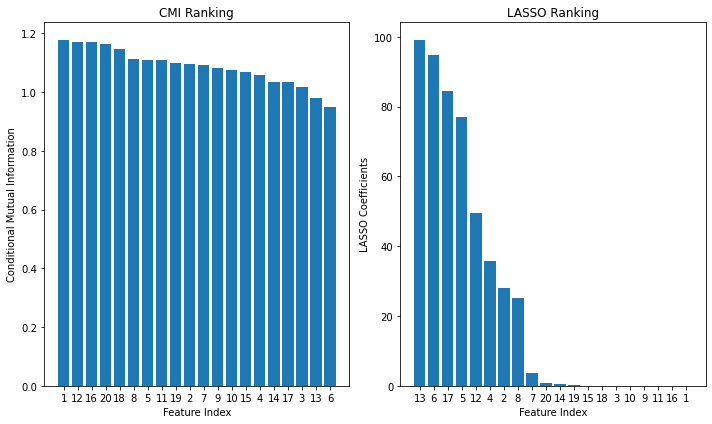

Top 10 zmiennych na podstawie CMI: [ 1 12 16 20 18  8  5 11 19  2]
Top 10 zmiennych na podstawie LASSO: [13  6 17  5 12  4  2  8  7 20]
Liczba odwróconych par: 95
Top 10 agreement score: 0.5
Top 5 agreement score: 0.2


In [43]:
#est2

cmi_scores = []
for i in range(X.shape[1]):
    # Zmienna Z to wszystkie cechy oprócz jednej
    Z = np.delete(X, i, axis=1)
    cmi_scores.append(est2(X[:, i].reshape(-1, 1), Y, Z))

# Ranking zmiennych na podstawie CMI
cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_features + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, n_features + 1), np.array(lasso_importances)[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlanie top 10 zmiennych
print("Top 10 zmiennych na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 zmiennych na podstawie LASSO:", lasso_ranking[:10] + 1)


# Liczenie liczby odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Liczenie liczby przypadków, w których top 10 zmiennych się pokrywają
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Top 10 agreement score: {top_k_agreement_10}")
print(f"Top 5 agreement score: {top_k_agreement_5}")

I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0.016527817036896764
I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0.022118706027732138
I_XZY: 0.5533305174120713
I_XY: 0.07695074422074022
I_XZY: 0.5533305174120713
I_XY: 0.12460468279635073
I_XZY: 0.5533305174120713
I_XY: 0.014830603117033547
I_XZY: 0.5533305174120713
I_XY: 0.007353375880041035
I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0.03464103228225124
I_XZY: 0.5533305174120713
I_XY: 0.14187779840545023
I_XZY: 0.5533305174120713
I_XY: 0.003362905142744843
I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0.005491157195736562
I_XZY: 0.5533305174120713
I_XY: 0.10393792529912105
I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0
I_XZY: 0.5533305174120713
I_XY: 0.0016337700079729345


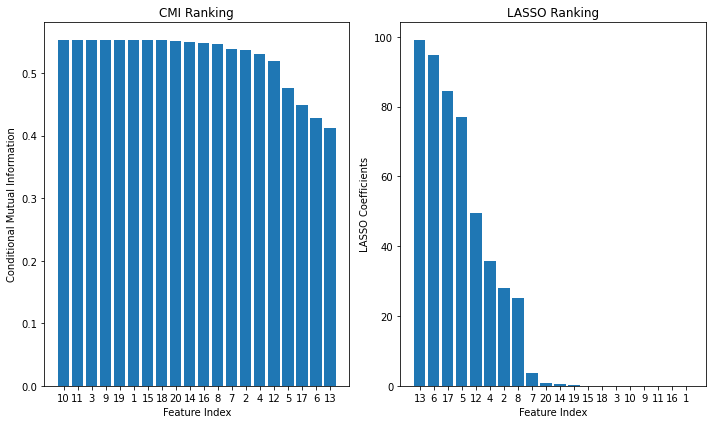

Top 10 zmiennych na podstawie CMI: [10 11  3  9 19  1 15 18 20 14]
Top 10 zmiennych na podstawie LASSO: [13  6 17  5 12  4  2  8  7 20]
Liczba odwróconych par: 106
Top 10 agreement score: 0.1
Top 5 agreement score: 0.0


In [112]:
cmi_scores = []
for i in range(X.shape[1]):
    # Zmienna Z to wszystkie cechy oprócz jednej
    Z = np.delete(X, i, axis=1)
    cmi_scores.append(estimate_cmi(X[:, i].reshape(-1, 1), Y.ravel(), Z))

# Ranking zmiennych na podstawie CMI
cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_features + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, n_features + 1), np.array(lasso_importances)[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlanie top 10 zmiennych
print("Top 10 zmiennych na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 zmiennych na podstawie LASSO:", lasso_ranking[:10] + 1)

# Liczenie liczby odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Liczenie liczby przypadków, w których top 10 zmiennych się pokrywają
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Top 10 agreement score: {top_k_agreement_10}")
print(f"Top 5 agreement score: {top_k_agreement_5}")

### 2 przykład 2

In [ ]:
#generowanie danych
n_samples = 10000
n_features = 20

X = np.random.rand(n_samples, n_features)

Y = (
    3 * X[:, 0] +                    
    2 * X[:, 1] ** 2 +               
    4 * np.sin(2 * np.pi * X[:, 2]) + 
    X[:, 3] * X[:, 4] +              
    np.random.normal(0, 0.1, n_samples) 
)


X[:, 10:] += np.random.normal(0, 0.1, size=(n_samples, n_features - 10))

# Generowanie modelu LassoCV i obliczanie ważności zmiennych
lasso = LassoCV(cv=5).fit(X, Y)
lasso_importances = np.abs(lasso.coef_)
lasso_ranking = np.argsort(lasso_importances)[::-1]

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6169 - val_loss: 0.0800 - learning_rate: 1.0000e-04
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3453 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2013 - val_loss: 0.0500 - learning_rate: 1.0000e-04
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1507 - val_loss: 0.0399 - learning_rate: 1.0000e-04
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1347 - val_loss: 0.0311 - learning_rate: 1.0000e-04
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0958 - val_loss: 0.0267 - learning_rate: 1.0000e-04
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0985 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0520 - val_loss: 0.0144 - learning_rate: 1.0000e-04
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0614 - val_loss: 

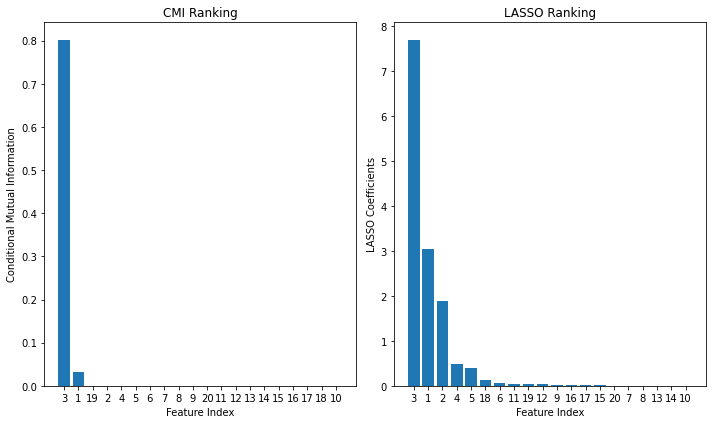

Top 10 zmiennych na podstawie CMI: [ 3  1 19  2  4  5  6  7  8  9]
Top 10 zmiennych na podstawie LASSO: [ 3  1  2  4  5 18  6 11 19 12]
Liczba odwróconych par: 75
Top 10 agreement score: 0.7
Top 5 agreement score: 0.8


In [22]:
#est1

cmi_scores = []
for i in range(X.shape[1]):
    Z = np.delete(X, i, axis=1) 
    cmi_scores.append(est1(X[:, i].reshape(-1, 1), Y.reshape(-1, 1), Z))


cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_features + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, n_features + 1), lasso_importances[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlamy top 10 zmiennych
print("Top 10 zmiennych na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 zmiennych na podstawie LASSO:", lasso_ranking[:10] + 1)



# Liczenie liczby odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Liczenie liczby przypadków, w których top 10 zmiennych się pokrywają
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Top 10 agreement score: {top_k_agreement_10}")
print(f"Top 5 agreement score: {top_k_agreement_5}")


Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.6704 - val_loss: 0.0115 - learning_rate: 1.0000e-04
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3222 - val_loss: -0.1004 - learning_rate: 1.0000e-04
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1268 - val_loss: -0.1585 - learning_rate: 1.0000e-04
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0783 - val_loss: -0.2003 - learning_rate: 1.0000e-04
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0238 - val_loss: -0.2336 - learning_rate: 1.0000e-04
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: -0.0368 - val_loss: -0.2643 - learning_rate: 1.0000e-04
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.0903 - val_loss: -0.2854 - learning_rate: 1.0000e-04
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: -0.1077 - val_loss: -0.3027 - learning_rate: 1.0000e-04
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 

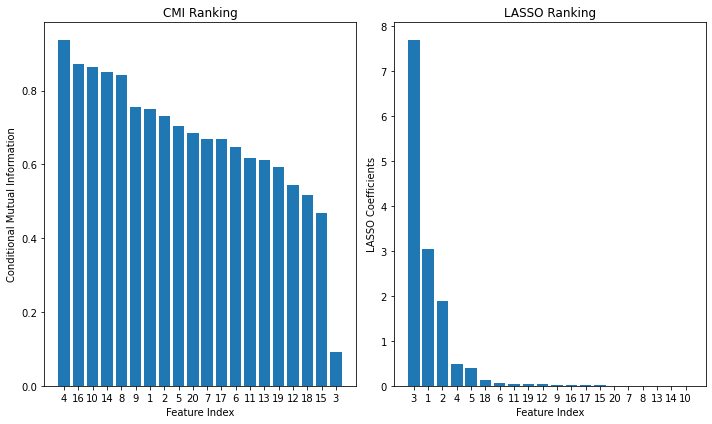

Top 10 zmiennych na podstawie CMI: [ 4 16 10 14  8  9  1  2  5 20]
Top 10 zmiennych na podstawie LASSO: [ 3  1  2  4  5 18  6 11 19 12]
Liczba odwróconych par: 97
Top 10 agreement score: 0.4
Top 5 agreement score: 0.2


In [44]:
#est2

cmi_scores = []
for i in range(X.shape[1]):
    Z = np.delete(X, i, axis=1)  
    cmi_scores.append(est2(X[:, i].reshape(-1, 1), Y.reshape(-1, 1), Z))

# Ranking zmiennych na podstawie CMI
cmi_ranking = np.argsort(cmi_scores)[::-1]


# Wizualizacja rankingów
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_features + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, n_features + 1), lasso_importances[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlamy top 10 zmiennych
print("Top 10 zmiennych na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 zmiennych na podstawie LASSO:", lasso_ranking[:10] + 1)



# Liczenie liczby odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Liczenie liczby przypadków, w których top 10 zmiennych się pokrywają
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Top 10 agreement score: {top_k_agreement_10}")
print(f"Top 5 agreement score: {top_k_agreement_5}")


I_XZY: 1.1924219245481318
I_XY: 0.14719406219425046
I_XZY: 1.1924219245481318
I_XY: 0.06119170239935379
I_XZY: 1.1924219245481318
I_XY: 0.9648731364794436
I_XZY: 1.1924219245481318
I_XY: 0.007549875605306511
I_XZY: 1.1924219245481318
I_XY: 0.0014050718141627172
I_XZY: 1.1924219245481318
I_XY: 0.0003673274987905373
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0.0032639896893877918
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0.003456393848982664
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0.003120365018453697
I_XZY: 1.1924219245481318
I_XY: 0
I_XZY: 1.1924219245481318
I_XY: 0


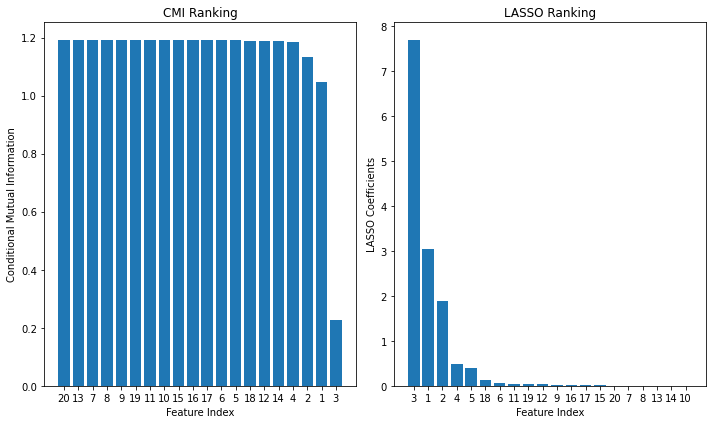

Top 10 zmiennych na podstawie CMI: [20 13  7  8  9 19 11 10 15 16]
Top 10 zmiennych na podstawie LASSO: [ 3  1  2  4  5 18  6 11 19 12]
Liczba odwróconych par: 95
Top 10 agreement score: 0.2
Top 5 agreement score: 0.0


In [114]:
#est3

cmi_scores = []
for i in range(X.shape[1]):
    Z = np.delete(X, i, axis=1)  
    cmi_scores.append(estimate_cmi(X[:, i].reshape(-1, 1), Y.ravel(), Z))

# Ranking zmiennych na podstawie CMI
cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_features + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, n_features + 1), lasso_importances[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlamy top 10 zmiennych
print("Top 10 zmiennych na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 zmiennych na podstawie LASSO:", lasso_ranking[:10] + 1)



# Liczenie liczby odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Liczenie liczby przypadków, w których top 10 zmiennych się pokrywają
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Top 10 agreement score: {top_k_agreement_10}")
print(f"Top 5 agreement score: {top_k_agreement_5}")


 ## dataset example of ranking variable importance.

### 3 przykład 1


In [ ]:
# Wczytanie zbioru danych California Housing
housing = fetch_california_housing()
X = housing.data
Y = housing.target.reshape(-1, 1)

n_samples = 20000
X = X[:n_samples]
Y = Y[:n_samples]

# Ranking cech na podstawie LASSO
lasso = LassoCV(cv=5).fit(X, Y.ravel())
lasso_importances = np.abs(lasso.coef_)
lasso_ranking = np.argsort(lasso_importances)[::-1]

Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.8047 - val_loss: 0.0356 - learning_rate: 1.0000e-04
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2863 - val_loss: 0.0550 - learning_rate: 1.0000e-04
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1575 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1257 - val_loss: 0.2083 - learning_rate: 1.0000e-04
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0908 - val_loss: 0.2406 - learning_rate: 1.0000e-04
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0809 - val_loss: 0.2589 - learning_rate: 1.0000e-04
Epoch 7/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0658 - val_loss: 0.1580 - learning_rate: 5.0000e-05
Epoch 8/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0642 - val_loss: 0.1790 - learning_rate: 5.0000e-05
Epoch 9/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0595 - val_loss:

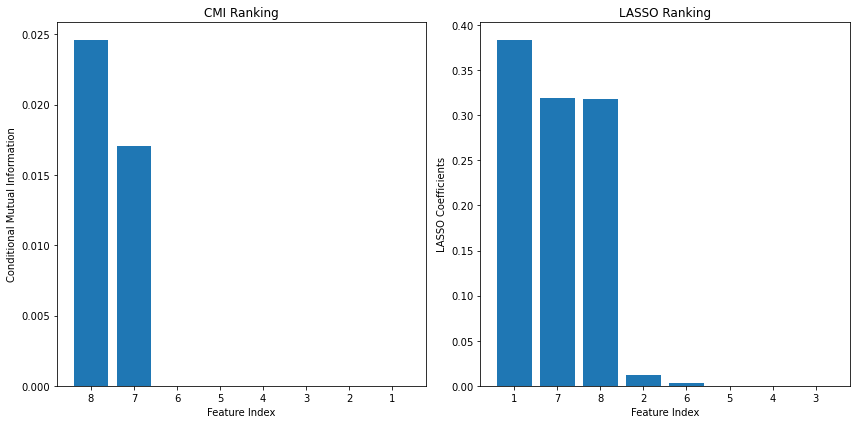

Top 10 cech na podstawie CMI: [8 7 6 5 4 3 2 1]
Top 10 cech na podstawie LASSO: [1 7 8 2 6 5 4 3]
Liczba odwróconych par: 12
Zgodność top 10: 0.80
Zgodność top 5: 0.60


In [50]:
#est1

cmi_scores = []
for i in range(X.shape[1]):
    Z = np.delete(X, i, axis=1)
    cmi_scores.append(est1(X[:, i].reshape(-1, 1), Y, Z))

# Ranking cech na podstawie CMI
cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, X.shape[1] + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, X.shape[1] + 1), np.array(lasso_importances)[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlenie top 10 cech
print("Top 10 cech na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 cech na podstawie LASSO:", lasso_ranking[:10] + 1)


# Liczba odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Zgodność w top-10 i top-5
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Zgodność top 10: {top_k_agreement_10:.2f}")
print(f"Zgodność top 5: {top_k_agreement_5:.2f}")


Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 2.9533 - val_loss: 0.1292 - learning_rate: 1.0000e-04
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3912 - val_loss: 0.1327 - learning_rate: 1.0000e-04
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1959 - val_loss: 0.1041 - learning_rate: 1.0000e-04
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1487 - val_loss: 0.0573 - learning_rate: 1.0000e-04
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0936 - val_loss: 0.0545 - learning_rate: 1.0000e-04
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0806 - val_loss: 0.0423 - learning_rate: 1.0000e-04
Epoch 7/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0766 - val_loss: 0.0263 - learning_rate: 1.0000e-04
Epoch 8/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0631 - val_loss: 0.0253 - learning_rate: 1.0000e-04
Epoch 9/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0560 - val_

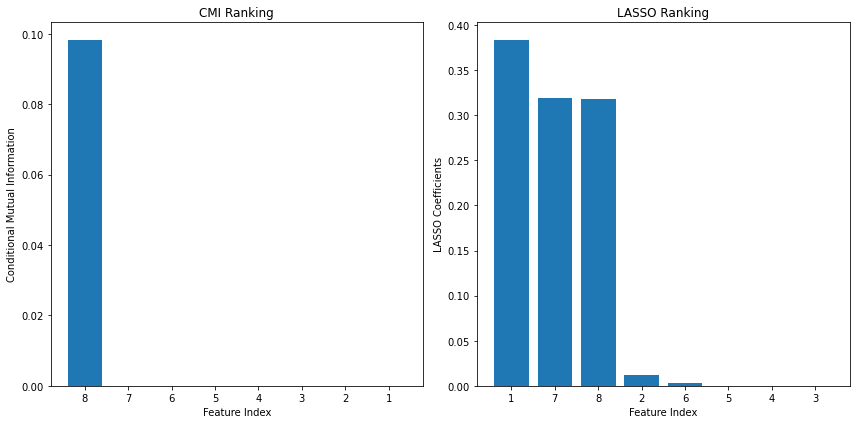

Top 10 cech na podstawie CMI: [8 7 6 5 4 3 2 1]
Top 10 cech na podstawie LASSO: [1 7 8 2 6 5 4 3]
Liczba odwróconych par: 12
Zgodność top 10: 0.80
Zgodność top 5: 0.60


In [51]:
#est2

cmi_scores = []
for i in range(X.shape[1]):
    Z = np.delete(X, i, axis=1)
    cmi_scores.append(est2(X[:, i].reshape(-1, 1), Y, Z))


cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, X.shape[1] + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, X.shape[1] + 1), np.array(lasso_importances)[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlenie top 10 cech
print("Top 10 cech na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 cech na podstawie LASSO:", lasso_ranking[:10] + 1)


# Liczba odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Zgodność w top-10 i top-5
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Zgodność top 10: {top_k_agreement_10:.2f}")
print(f"Zgodność top 5: {top_k_agreement_5:.2f}")


I_XZY: 1.3216262675167103
I_XY: 0.3736867937255788
I_XZY: 1.3224666700137968
I_XY: 0.023811675906504348
I_XZY: 1.3200463384684182
I_XY: 0.0899042936006147
I_XZY: 1.3217727804107602
I_XY: 0.023380453342102037
I_XZY: 1.322558649908494
I_XY: 0.013050011195638866
I_XZY: 1.3203243356312742
I_XY: 0.07856446901611136
I_XZY: 1.3240170194136898
I_XY: 0.32952265192257624
I_XZY: 1.3214433077374528
I_XY: 0.38985652516672253


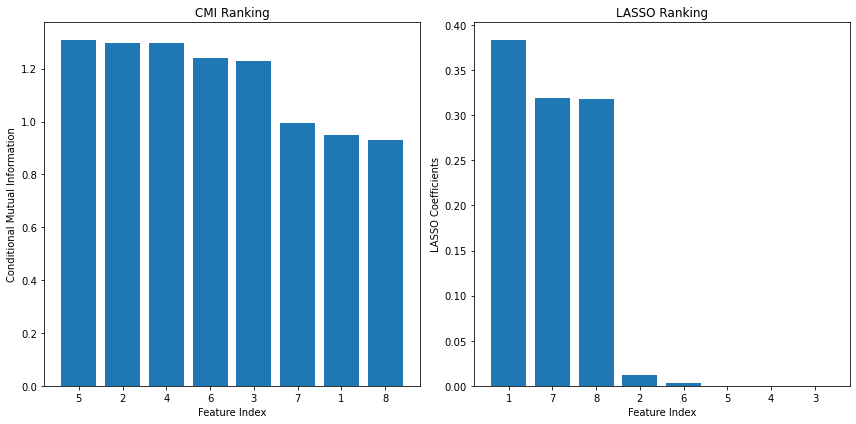

Top 10 cech na podstawie CMI: [5 2 4 6 3 7 1 8]
Top 10 cech na podstawie LASSO: [1 7 8 2 6 5 4 3]
Liczba odwróconych par: 17
Zgodność top 10: 0.80
Zgodność top 5: 0.40


In [111]:
#est3

cmi_scores = []
for i in range(X.shape[1]):
    Z = np.delete(X, i, axis=1)
    cmi_scores.append(estimate_cmi(X[:, i].reshape(-1, 1), Y.ravel(), Z))

cmi_ranking = np.argsort(cmi_scores)[::-1]

# Wizualizacja rankingów
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, X.shape[1] + 1), np.array(cmi_scores)[cmi_ranking], tick_label=cmi_ranking + 1)
plt.title("CMI Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Conditional Mutual Information")

plt.subplot(1, 2, 2)
plt.bar(range(1, X.shape[1] + 1), np.array(lasso_importances)[lasso_ranking], tick_label=lasso_ranking + 1)
plt.title("LASSO Ranking")
plt.xlabel("Feature Index")
plt.ylabel("LASSO Coefficients")

plt.tight_layout()
plt.show()

# Wyświetlenie top 10 cech
print("Top 10 cech na podstawie CMI:", cmi_ranking[:10] + 1)
print("Top 10 cech na podstawie LASSO:", lasso_ranking[:10] + 1)


# Liczba odwróconych par
inversions = count_inversions(cmi_ranking, lasso_ranking)
print(f"Liczba odwróconych par: {inversions}")

# Zgodność w top-10 i top-5
top_k_agreement_10 = top_k_agreement(cmi_ranking, lasso_ranking, 10)
top_k_agreement_5 = top_k_agreement(cmi_ranking, lasso_ranking, 5)

print(f"Zgodność top 10: {top_k_agreement_10:.2f}")
print(f"Zgodność top 5: {top_k_agreement_5:.2f}")